In [2]:
import os
import warnings
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.io import imread,imshow
from skimage.transform import resize
from skimage.color import rgb2grey
from skimage import feature
import cv2


In [3]:
warnings.simplefilter("ignore")

In [4]:
bob = os.listdir(r"./mug_shots/bob//")
alice = os.listdir(r"./mug_shots/alice//")
charlie = os.listdir(r"./mug_shots/charlie//")

limit = 36#max no of images

bob_img = [None]*limit
alice_img = [None]*limit
charlie_img = [None]*limit


j = 0
i = 0
for i in bob:
    if(j < limit):
        bob_img[j] = imread(r"./mug_shots/bob//"+i)
        j += 1
    else:
        break
j = 0
i = 0
for i in charlie:
    if(j < limit):
        charlie_img[j] = imread(r"./mug_shots/charlie//"+i)
        j += 1
    else:
        break

j = 0
i = 0
for i in alice:
    if(j < limit):
        alice_img[j] = imread(r"./mug_shots/alice//"+i)
        j += 1
    else:
        break


#used to convert raw img to mug shots

n=0
for i in charlie_img:
    cropx = 2000
    cropy = 2000
    y,x,_ = i.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    new_img =  i[starty:starty+cropy,startx:startx+cropx]
    matplotlib.image.imsave(str(n)+'.png', new_img)
    print(n)
    n+=1


In [5]:
#converting to gray scale

bob_grey      = [None]*limit
charlie_grey  = [None]*limit
alice_grey    = [None]*limit

x = 0
for i in bob_img:
    bob_grey[x] = rgb2grey(i)
    x+=1

x = 0
for i in charlie_img:
    charlie_grey[x] = rgb2grey(i)
    x+=1
    
x = 0
for i in alice_img:
    alice_grey[x] = rgb2grey(i)
    x+=1

In [6]:
imSize=(25,25)

for i in range(limit):
    bob_grey[i]     = resize(bob_grey[i],imSize)
    charlie_grey[i] = resize(charlie_grey[i],imSize)
    alice_grey[i]   = resize(alice_grey[i],imSize)



In [7]:
nCol = bob_grey[0].shape[0]*bob_grey[0].shape[1]
print(nCol)

#dimensions of bob_grey[i] is 40x40 right now,
#need to convert it into array of 1600*1
#basically flattening the 40 by 40 matrix into a 1600 by 1 matrix
#putting all the rows together in a single row

for i in range(limit):
    bob_grey[i]     = np.ndarray.flatten(bob_grey[i]).reshape(nCol,1)
    charlie_grey[i] = np.ndarray.flatten(charlie_grey[i]).reshape(nCol,1)
    alice_grey[i]   = np.ndarray.flatten(alice_grey[i]).reshape(nCol,1)

bob_grey     = np.dstack(bob_grey)
charlie_grey = np.dstack(charlie_grey)
alice_grey   = np.dstack(alice_grey)

bob_grey     = np.rollaxis(bob_grey, axis=2, start=0)
charlie_grey = np.rollaxis(charlie_grey, axis=2, start=0)
alice_grey   = np.rollaxis(alice_grey, axis=2, start=0)

bob_grey     = bob_grey.reshape(limit,nCol)
charlie_grey = charlie_grey.reshape(limit,nCol)
alice_grey   = alice_grey.reshape(limit,nCol)

bob_data     = pd.DataFrame(bob_grey)
charlie_data = pd.DataFrame(charlie_grey)
alice_data   = pd.DataFrame(alice_grey)

bob_data["label"]      ="BOB"
charlie_data["label"]  ="CHARLIE"
alice_data["label"]    ="ALICE"

first_pair = pd.concat([bob_data,charlie_data])
faces = pd.concat([first_pair,alice_data])

from sklearn.utils import shuffle
out = shuffle(faces).reset_index()
out = out.drop(['index'],axis=1)

x = out.values[:,:-1]
y = out.values[:,-1]

625


In [8]:
from sklearn.decomposition import PCA                      # principle component analysis, decompose face into its features
from sklearn.svm import SVC                                # support vector classifier, the ml models class
from sklearn.pipeline import make_pipeline                 # support function for GridSearchCV
from sklearn.model_selection import train_test_split       # split training and testing data
from sklearn.model_selection import GridSearchCV           # func to find the best parameters
from sklearn import metrics                                # accuracy finder

In [9]:
#principle component analysis
#decomposes the face into its individual features.
# n_components = number of components the face will be split into
# whiten = ??
# random_state = 0
pca = PCA(n_components=15, whiten=False, random_state=0)

#support vector classifier.
#draws a straigt line b/w two classes, i.e. classifies the classes into two parts for classification
svc = SVC(kernel='rbf', class_weight='balanced')

model = make_pipeline(pca, svc)

In [10]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=0)#splitting training and testing data.

In [11]:
params = {'svc__C': [x for x in range(1,5)],'svc__gamma': [0.001, 0.005, 0.006,0.01,0.05,0.06,0.004,0.04]}

#
grid = GridSearchCV(model, params)
%time grid.fit(x_train, y_train)
print(grid.best_params_)

Wall time: 1.55 s
{'svc__C': 1, 'svc__gamma': 0.06}


In [12]:
model = grid.best_estimator_
yfit = model.predict(x_test)

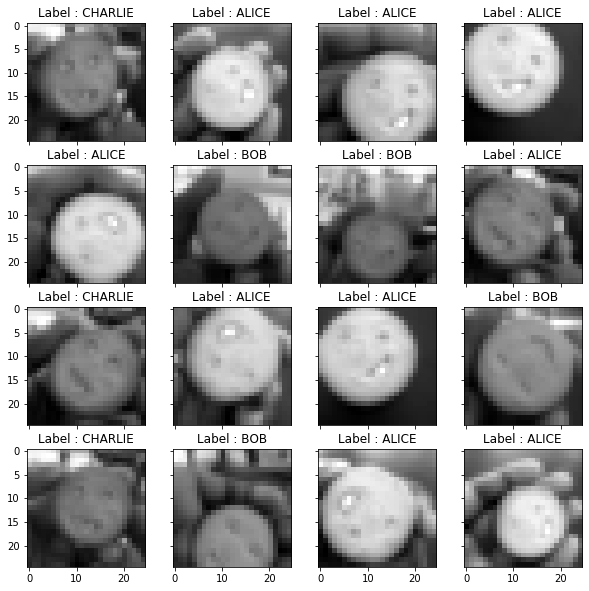

In [13]:
fig, ax = plt.subplots(4,4,sharex=True,sharey=True,figsize = (10,10))
for i, axi in enumerate(ax.flat):
    axi.imshow(x_test[i].reshape(imSize).astype(np.float64),cmap = "gray",interpolation = "nearest")
    axi.set_title('Label : {}'.format(yfit[i]),)

In [14]:
print(metrics.accuracy_score(y_test,yfit))

0.8148148148148148
